# Word2Vec 


## Модель дистрибутивной семантики. Реализация с помощью PyTorch

In [2]:
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

In [3]:
import re
import collections

Датасет - англоязычный набор данных Рецепты еды.

Его рассматривают на семинаре.

Источник: [https://github.com/nytimes/ingredient-phrase-tagger/tree/master]

In [4]:
df=pd.read_csv('../dataset/_itog_.csv', delimiter='\t',index_col=0)


In [5]:
df

,Новостройки,Автор отзыва,Отзыв,Отзывы очищенные,RuterExtractor,Ключевые слова KEYBERT,All_KeyBert,Ключевые слова RAKE,All_RAKE,Ключевые слова YAKE,Все ключевые слова YAKE
0,По ул. Соловьиная,Любовь Чистякова,Продавцы вежливые внимательные. Продукты вседа...,продавцы вежливые внимательные продукты вседа ...,"свежие дорогое сливочное масло, вежливые внима...","['только очень дорогое сливочное масло', 'прод...","только очень дорогое сливочное масло,продавцы ...","['продавцы вежливые внимательные', 'продукты в...","продавцы вежливые внимательные,продукты вседа ...","['Продавцы вежливые внимательные', 'Продавцы',...","Продавцы вежливые внимательные,Продавцы,внимат..."
1,По ул. Соловьиная,Инкогнито 9678,Очень спокойный и тихий район,очень спокойный тихий район,спокойный тихий район,"['тихий район', 'очень']","тихий район,очень","['тихий район', 'спокойный']","тихий район,спокойный","['спокойный и тихий район', 'район', 'спокойны...","спокойный и тихий район,район,спокойный,тихий"
2,По ул. Соловьиная,Любовь Янченко,"Неплохие квартиры, хорошие большие лифты, детс...",неплохие квартиры хорошие большие лифты детска...,"хорошие большие лифты, неплохие квартира, детс...","['хорошие большие лифты', 'детская площадка', ...","хорошие большие лифты,детская площадка,большая...","['хорошие большие лифты', 'неплохие квартиры',...","хорошие большие лифты,неплохие квартиры,детска...","['хорошие большие лифты', 'минус-высокая слыши...","хорошие большие лифты,минус-высокая слышимость..."
3,По ул. Соловьиная,Pavel Лебедев,"Место классное. Дома новые, лифты в домах объё...",место классное дома новые лифты домах объёмные...,"объёмные удобные квартира, новые лифты, классн...","['район очень перспективный', 'но надеюсь скор...","район очень перспективный,но надеюсь скоро всё...","['место классное', 'дома новые', 'домах объёмн...","место классное,дома новые,домах объёмные,кварт...","['Место классное', 'лифты в домах объёмные', '...","Место классное,лифты в домах объёмные,Место,До..."
4,По ул. Соловьиная,Юлия Черменева,Стоит жудкий запах канализации!!! С Васильески...,стоит жудкий запах канализации васильеских оск,"запах канализации, жудкий",['стоит жудкий запах'],стоит жудкий запах,"['стоит жудкий запах канализации', 'васильески...","стоит жудкий запах канализации,васильеских оск","['Стоит жудкий запах канализации', 'Стоит жудк...","Стоит жудкий запах канализации,Стоит жудкий,Ва..."
...,...,...,...,...,...,...,...,...,...,...,...
554,Парковый,Сергей,"Дома хорошие, застройка плотная слишком.",дома хорошие застройка плотная слишком,"хорошие застройка, дом","['застройка плотная слишком', 'дома хорошие']","застройка плотная слишком,дома хорошие","['дома хорошие', 'застройка плотная']","дома хорошие,застройка плотная","['Дома хорошие', 'застройка плотная', 'Дома', ...","Дома хорошие,застройка плотная,Дома,плотная"
555,Парковый,Михаил Малышев,Очень комфортные квартиры.,очень комфортные квартиры,комфортные квартира,['очень комфортные квартиры'],очень комфортные квартиры,['комфортные квартиры'],комфортные квартиры,"['комфортные квартиры', 'квартиры']","комфортные квартиры,квартиры"
556,Парковый,Наталья К.,Красивые дома.,красивые дома,красивые дом,['красивые дома'],красивые дома,['красивые дома'],красивые дома,"['Красивые дома', 'дома']","Красивые дома,дома"
557,Парковый,Алесандр,Отлично. Буду там жить,отлично буду жить,NaN,['буду там жить'],буду там жить,"['отлично', 'жить']","отлично,жить","['Отлично', 'жить']","Отлично,жить"


In [6]:
full_dataset = list(pd.read_csv('../dataset/_itog_.csv', delimiter='\t',index_col=0)['Отзыв'].dropna())


In [7]:
full_dataset[115]

'Новый район, в хорошем месте.'

In [8]:
#full_dataset = list(pd.read_csv('../dataset/demo_diplom.csv')['All_KeyBert'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.9)
train_data = full_dataset[:TRAIN_VAL_SPLIT]
test_data = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_data))
print("Тестовая выборка", len(test_data))
print()
print('\n'.join(train_data[:5]))

Обучающая выборка 503
Тестовая выборка 56

Новый красивый дом, но фото не соответствует действительности, на первом этаже у корпуса 2 открыт магазин Магнит
Отлично
Прекрасный дом, двор, соседи. Видеонаблюдение. Парковка сделана вокруг дома , не проблема найти место, хоть и не прямо у подъезда.
Все удобно
Хотелось бы остановку рядом, и магазины поближе, всё очень далеко.


## Токенизация

In [9]:
TOKEN_RE = re.compile(r'[\w\d]+') 

def tokenize_text_simple_regex(txt, min_token_size=4):
    #print(txt)
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]

def character_tokenize(txt): 
    return list(txt)

def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs): 
    #print(texts)
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

In [10]:
# токенизируем
train_tokens = tokenize_corpus(train_data)
test_tokens = tokenize_corpus(test_data)

In [11]:
train_tokens[2]

['прекрасный',
 'двор',
 'соседи',
 'видеонаблюдение',
 'парковка',
 'сделана',
 'вокруг',
 'дома',
 'проблема',
 'найти',
 'место',
 'хоть',
 'прямо',
 'подъезда']

## Словарь из ингредиентов рецепта

In [12]:
# Метод, написанный преподавателями курса
def build_vocabulary(tokenized_texts, max_size=50000, max_doc_freq=0.89, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


PAD_TOKEN = '__PAD__'
NUMERIC_TOKEN = '__NUMBER__'
NUMERIC_RE = re.compile(r'^([0-9.,e+\-]+|[mcxvi]+)$', re.I)

In [13]:
vocabulary, word_doc_freq = build_vocabulary(train_tokens, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 272
[('<PAD>', 0), ('очень', 1), ('дома', 2), ('район', 3), ('рядом', 4), ('есть', 5), ('место', 6), ('хороший', 7), ('новый', 8), ('микрорайон', 9)]


#### PAD символ предназначен для выравнивания массивов в одну размерность для  преобразования в матрицу, облегчая обработку GPU

## Пронумирование токенов

In [14]:
def add_fake_token(word2id, token='<PAD>'):
    word2id_new = {token: i + 1 for token, i in word2id.items()}
    word2id_new[token] = 0
    return word2id_new


def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]


In [15]:
train_tkn_id = texts_to_token_ids(train_tokens, vocabulary)
test_tkn_id = texts_to_token_ids(test_tokens, vocabulary)


### Длины текстов

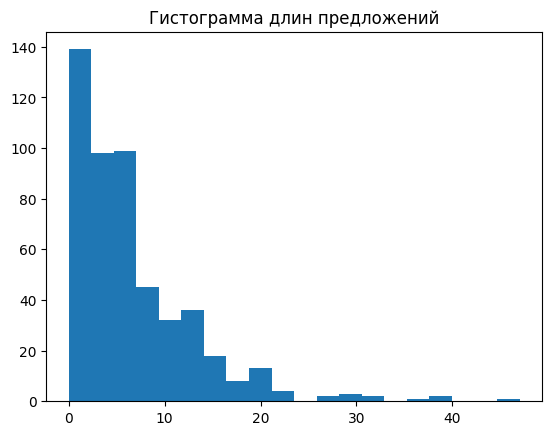

In [16]:
plt.hist([len(element) for element in train_tkn_id], bins=20);
plt.title('Гистограмма длин предложений');

## Преобразование в Тензор, для параллельной обработки

In [17]:
### Класс, разработанный преподавтелями курса.

### Решаемые задачи, благодаря новому классу.
#### Формирование датасета, каждой предложение в котором будет имеет одинкаовую длину 
#### Преобразование в Тензоре, что упростит обработку для GPU
import torch
from torch.utils.data import Dataset


def ensure_length(txt, out_len, pad_value):
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt


class PaddedSequenceDataset(Dataset):
    def __init__(self, texts, targets, out_len=100, pad_value=0):
        self.texts = texts
        self.targets = targets
        self.out_len = out_len
        self.pad_value = pad_value

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        txt = self.texts[item]

        txt = ensure_length(txt, self.out_len, self.pad_value)
        txt = torch.tensor(txt, dtype=torch.long)

        target = torch.tensor(self.targets[item], dtype=torch.long)

        return txt, target


In [18]:
MAX_SENTENCE_LEN = 20
train_info = PaddedSequenceDataset(train_tkn_id,
                                      np.zeros(len(train_tkn_id)),
                                      out_len=MAX_SENTENCE_LEN)
test_info = PaddedSequenceDataset(test_tkn_id,
                                     np.zeros(len(test_tkn_id)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_info[0])

(tensor([  8,  16, 218,  61, 146,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


## Алгоритм Word2Vec и обучение

### Реализация Word2Vec включает в себя два важных механизма:
- Skip Gram - предсказание соседних слов на основе центрального в рамках скользящего окна
- Negative Sampling - апроксимация softmax с построением распределения вероятностей и определением сходства




Задача обучения word2vec сводится к созданию класификатора, 
принимающий на вход два идентификатора слова, и отвечающий на вопроса совместно ли они расположены


In [19]:
### Моделирование прохождения скользящего окна
### Легче отследить факт совместной встречаемости

def diagonal_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

diagonal_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [20]:
### Класс, разработанный преподавтелями курса.
### Реализация алгоритма SkipGram-NegativeSampling
class Trainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = diagonal_mask(sentence_len, radius)
    
    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

In [21]:
trainer = Trainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)

## методы из курсы, перенесенные с github

In [22]:
import copy
import datetime
import random
import traceback
import numpy as np
import torch
from torch.utils.data import DataLoader

def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model


def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        import tqdm
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)
        
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))

## Построение модели Word2Vec через PyTorch

In [23]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_info,
                                            test_info,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=100,
                                            batch_size=512,
                                            device='cpu',
                                            early_stopping_patience=15,
                                            max_batches_per_epoch_train=10000,
                                            max_batches_per_epoch_val=len(test_info),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

/home/michalik/github/course_work/stepik_coursework_TextProcessing/All_Completed_Tasks_/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Эпоха 0
Эпоха: 1 итераций, 0.19 сек
Среднее значение функции потерь на обучении 0.9877349138259888
Среднее значение функции потерь на валидации 0.9876680374145508
Новая лучшая модель!

Эпоха 1
Эпоха: 1 итераций, 0.07 сек
Среднее значение функции потерь на обучении 0.9876483678817749
Среднее значение функции потерь на валидации 0.9867637157440186
Новая лучшая модель!

Эпоха 2
Эпоха: 1 итераций, 0.04 сек
Среднее значение функции потерь на обучении 0.9867085218429565
Среднее значение функции потерь на валидации 0.9850157499313354
Новая лучшая модель!

Эпоха 3
Эпоха: 1 итераций, 0.04 сек
Среднее значение функции потерь на обучении 0.9849084615707397
Среднее значение функции потерь на валидации 0.9819341897964478
Новая лучшая модель!

Эпоха 4
Эпоха: 1 итераций, 0.04 сек
Среднее значение функции потерь на обучении 0.9817297458648682
Среднее значение функции потерь на валидации 0.9773707389831543
Новая лучшая модель!

Эпоха 5
Эпоха: 1 итераций, 0.03 сек
Среднее значение функции потерь на обуч

## Применение модели Word2Vec через Pytorch

In [24]:

## Класс, разработанный преподавателями. 
## Цель - Извлечь вектора по слову
class Embeddings:
    def __init__(self, embeddings, word2id):
        self.embeddings = embeddings
        self.embeddings /= (np.linalg.norm(self.embeddings, ord=2, axis=-1, keepdims=True) + 1e-4)
        self.word2id = word2id
        self.id2word = {i: w for w, i in word2id.items()}

    def get_vector(self, word):
        if word not in self.word2id:
            raise ValueError('Неизвестное слово "{}"'.format(word))
        return self.embeddings[self.word2id[word]]

    def get_vectors(self, *words):
        word_ids = [self.word2id[i] for i in words  if i in self.word2id ]
        vectors = np.stack([self.embeddings[i] for i in word_ids], axis=0)
        return vectors
    def most_similar(self, word, topk=10):
        return self.most_similar_by_vector(self.get_vector(word), topk=topk)

    def analogy(self, a1, b1, a2, topk=10):
        a1_v = self.get_vector(a1)
        b1_v = self.get_vector(b1)
        a2_v = self.get_vector(a2)
        query = b1_v - a1_v + a2_v
        return self.most_similar_by_vector(query, topk=topk)

    def most_similar_by_vector(self, query_vector, topk=10):
        similarities = (self.embeddings * query_vector).sum(-1)
        best_indices = np.argpartition(-similarities, topk, axis=0)[:topk]
        result = [(self.id2word[i], similarities[i]) for i in best_indices]
        result.sort(key=lambda pair: -pair[1])
        return result


In [25]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
def plot_vectors(vectors, labels, how='tsne', ax=None):
    if how == 'tsne':

        tsne = TSNE(verbose=1,perplexity=40,n_iter=250,learning_rate=50, random_state=0,
              metric='mahalanobis')
        #projections = TSNE().fit_transform(vectors)
        tsne_results = tsne.fit_transform(vectors)
    elif how == 'svd':
        projections = TruncatedSVD().fit_transform(vectors)

    x = projections[:, 0]
    y = projections[:, 1]

    ax.scatter(x, y)
    for cur_x, cur_y, cur_label in zip(x, y, labels):
        ax.annotate(cur_label, (cur_x, cur_y))

In [26]:
embed = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [27]:
embed.most_similar('парковка')

[('парковка', 0.9998673),
 ('двор', 0.99246544),
 ('удобная', 0.99228865),
 ('внутри', 0.9922869),
 ('отлично', 0.992199),
 ('дома', 0.9919906),
 ('хорошие', 0.9919598),
 ('красивый', 0.991785),
 ('парковки', 0.99174196),
 ('есть', 0.9916996)]

In [28]:
import itertools
df['All_KeyBert']=df['All_KeyBert'].fillna("x")
phrases = []
for x in df['All_KeyBert']:
  #print(type(x))
  x=x.lower()
  phrases.append(x.split(sep=','))

bert_key=list(itertools.chain(*phrases))


In [29]:
bert_key


['только очень дорогое сливочное масло',
 'продавцы вежливые внимательные',
 'продукты вседа',
 'тихий район',
 'очень',
 'хорошие большие лифты',
 'детская площадка',
 'большая парковка',
 'жильцы вежливые',
 'минус',
 'район очень перспективный',
 'но надеюсь скоро всё поставят',
 'место классное',
 'доведут до ума',
 'правда тут ещё',
 'стоит жудкий запах',
 'нам нравится',
 'покупайте',
 'хорошие',
 'x',
 'от слова совсем',
 'парковок нет',
 'мало парковочных мест',
 'очень сложно',
 'проезжать',
 'район не плохой',
 'но все время холодно',
 'задержали сроки сдачи',
 'месторасположение хорошее',
 'все остальное супер',
 'не заезда',
 'дом новый',
 'тихое место',
 'инфраструктура появляется',
 'хорошая местность',
 'очень',
 'x',
 'ужасная дорога',
 'дворы чистые',
 'все красиво',
 'этим домам',
 'всё отлично',
 'здесь живу',
 'отличный дом',
 'обычный многоквартирный дом',
 'очень хороший лифт',
 'хороший тихий район',
 'новый дом',
 'всё хорошо',
 'на небольшую горку',
 'дома не ч

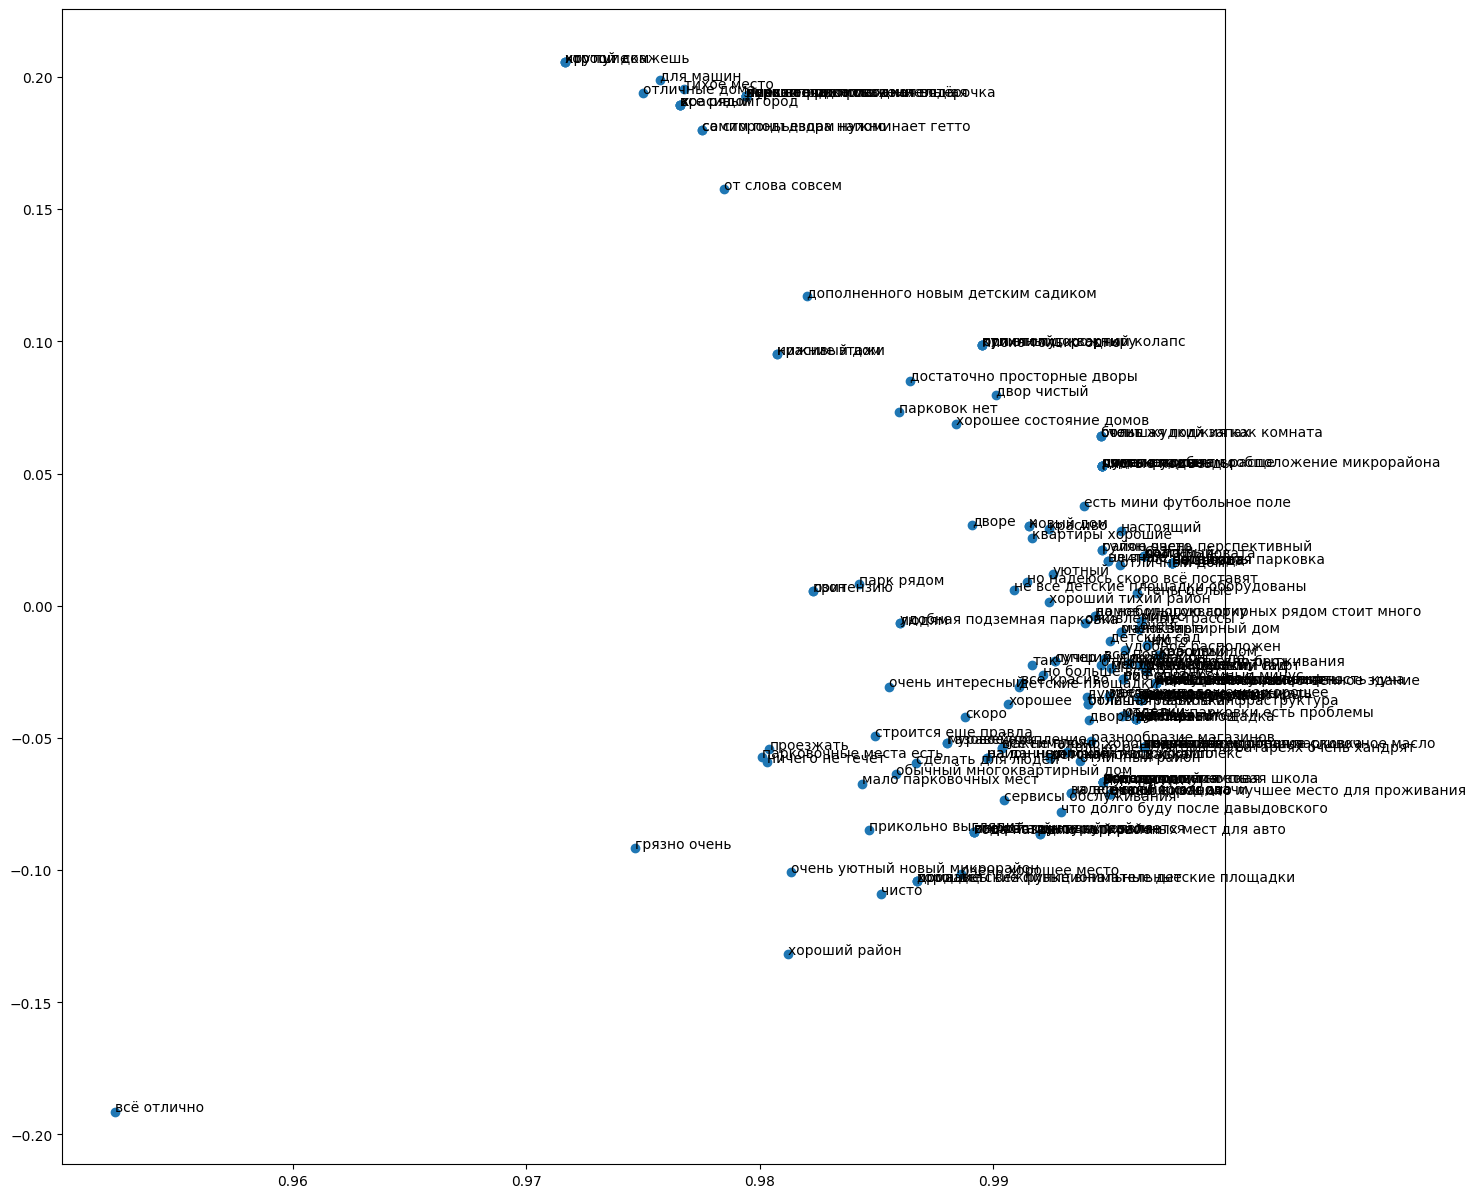

In [30]:
test_words = bert_key
test_vectors = embed.get_vectors(*test_words)


fig, ax = plt.subplots()
fig.set_size_inches((15, 15))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)


Три кластера - напитки, мясо, алкоголь,

## Word2Vec при помощи Gensim

In [31]:
import gensim

In [32]:
word2vec = gensim.models.Word2Vec(sentences=train_tokens, vector_size=30,
                                  window=5, min_count=5, workers=4,
                                  sg=1, epochs=20)

In [33]:
words = list(w for w in word2vec.wv.index_to_key)

In [34]:
words

['очень',
 'дома',
 'район',
 'рядом',
 'есть',
 'место',
 'хороший',
 'только',
 'новый',
 'микрорайон',
 'детские',
 'магазины',
 'площадки',
 'квартиры',
 'много',
 'отличный',
 'комплекс',
 'красивый',
 'дороги',
 'города',
 'будет',
 'домов',
 'квартиру',
 'инфраструктура',
 'этом',
 'хорошо',
 'школа',
 'можно',
 'хорошее',
 'доступности',
 'нравится',
 'хорошие',
 'площадка',
 'детская',
 'если',
 'качество',
 'шаговой',
 'парк',
 'здесь',
 'было',
 'хорошая',
 'расположение',
 'парковка',
 'вообще',
 'когда',
 'магазинов',
 'живу',
 'чистый',
 'детский',
 'чисто',
 'воздух',
 'мест',
 'красиво',
 'жилой',
 'школы',
 'доме',
 'просто',
 'конечно',
 'тихий',
 'зимой',
 'уютный',
 'проживания',
 'окна',
 'двор',
 'остановки',
 'транспорта',
 'отопление',
 'дорог',
 'новые',
 'магазин',
 'парковки',
 'места',
 'стены',
 'всех',
 'тихо',
 'красивые',
 'хватает',
 'надо',
 'этот',
 'мало',
 'которые',
 'садик',
 'проблемы',
 'пока',
 'отлично',
 'сейчас',
 'жить',
 'минус',
 'дворы',

In [35]:
gensim_words = [w for w in bert_key[:550] if w in word2vec.wv.key_to_index]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

In [36]:
try:
    vec_cameroon = word2vec.wv['парковка']
except KeyError:
    print("The word 'cameroon' does not appear in this model")

In [37]:
vec_cameroon

array([ 2.85705365e-02, -2.51696616e-01,  3.72475386e-01, -3.41101848e-02,
        1.48014426e-01, -2.45330506e-04,  1.32641509e-01, -4.10202406e-02,
       -3.40336919e-01,  9.38451141e-02,  4.37709123e-01,  2.39285454e-01,
        8.32560956e-02, -2.38827318e-01,  1.18895685e-02, -1.81399941e-01,
        6.04490079e-02,  1.20375156e-01, -4.50094283e-01, -1.50567994e-01,
       -1.28036454e-01, -5.12053855e-02,  1.94333866e-01,  5.18695056e-01,
        1.87517092e-01,  1.36796981e-01,  1.72540814e-01,  1.73733085e-01,
        3.68414819e-02, -3.22468579e-01], dtype=float32)

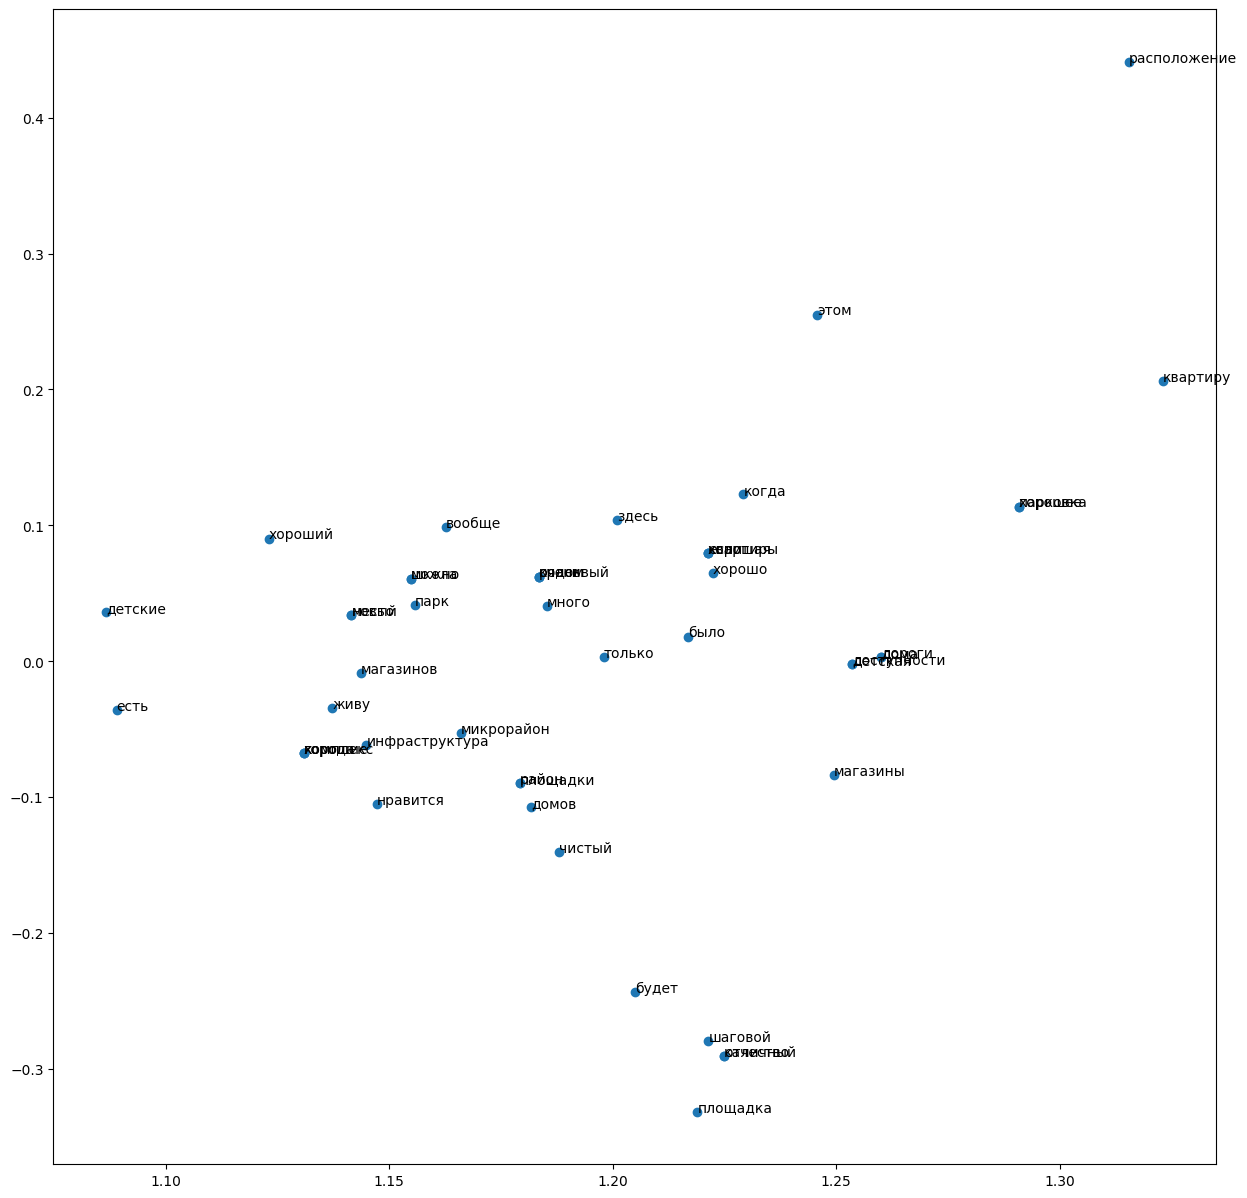

In [38]:
import mplcursors
fig, ax = plt.subplots()
fig.set_size_inches((15,15))
mplcursors.cursor(multiple = True).connect(
    "add", lambda sel: sel.annotation.set_text(
          test_words[sel.target.index]
))
plot_vectors(gensim_vectors, words, how='svd', ax=ax)


In [39]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(word2vec, 25)
# Derive the vector for the word "science" in our model
vector = word2vec.wv["парковка"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('парковка', 1.0)
('чисто', 0.9886019827419509)
('хороший', 0.9881565560304164)
('магнит', 0.9880739451834487)
('места', 0.9877729417638679)
('двор', 0.9872280351502319)
('хорошие', 0.9872028232924808)
('большие', 0.9854816189193184)
('хорошая', 0.983840343491856)
('большая', 0.9834012976961483)
('достаточно', 0.9830506426990868)

Exact Neighbors
('парковка', 0.9999998807907104)
('чисто', 0.9886019825935364)
('хороший', 0.9881565570831299)
('магнит', 0.9880738258361816)
('места', 0.9877730011940002)
('двор', 0.9872279167175293)
('хорошие', 0.9872028231620789)
('большие', 0.985481321811676)
('хорошая', 0.9838403463363647)
('жильцов', 0.983797013759613)
('большая', 0.9834011793136597)


In [158]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(word2vec, 25)
# Derive the vector for the word "science" in our model
vector = word2vec.wv["рядом"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

'''

'''

Approximate Neighbors
('расположение', 1.0)
('большие', 0.9892315863164488)
('удобная', 0.9866411081573925)
('минусов', 0.9865693445730268)
('места', 0.9864696865675445)
('хороший', 0.9856894006297807)
('недалеко', 0.9843177786762243)
('находится', 0.9843000739289945)
('большой', 0.9842985265659133)
('новый', 0.9842975125528478)
('комплексе', 0.9839315423927112)

Exact Neighbors
('расположение', 1.0)
('большие', 0.989231526851654)
('удобная', 0.9866410493850708)
('минусов', 0.986569344997406)
('места', 0.9864697456359863)
('хороший', 0.9856893420219421)
('живут', 0.985291063785553)
('недалеко', 0.9843177795410156)
('находится', 0.9843000769615173)
('большой', 0.9842984080314636)
('новый', 0.984297513961792)


'\n\n'

In [145]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(word2vec, 25)
# Derive the vector for the word "science" in our model
vector = word2vec.wv["расположение"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)


Approximate Neighbors
('расположение', 1.0)
('большие', 0.9892315863164488)
('удобная', 0.9866411081573925)
('минусов', 0.9865693445730268)
('места', 0.9864696865675445)
('хороший', 0.9856894006297807)
('недалеко', 0.9843177786762243)
('находится', 0.9843000739289945)
('большой', 0.9842985265659133)
('новый', 0.9842975125528478)
('комплексе', 0.9839315423927112)

Exact Neighbors
('расположение', 1.0)
('большие', 0.989231526851654)
('удобная', 0.9866410493850708)
('минусов', 0.986569344997406)
('места', 0.9864697456359863)
('хороший', 0.9856893420219421)
('живут', 0.985291063785553)
('недалеко', 0.9843177795410156)
('находится', 0.9843000769615173)
('большой', 0.9842984080314636)
('новый', 0.984297513961792)


In [120]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(word2vec, 25)
# Derive the vector for the word "science" in our model
vector = word2vec.wv["площадка"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)




Approximate Neighbors
('площадка', 1.0)
('хорошая', 0.9829596850396597)
('парковки', 0.9767843486029885)
('парковка', 0.9767118672629874)
('места', 0.976582885965401)
('поликлиника', 0.9761258331857537)
('детская', 0.9755196528831335)
('большие', 0.9722936114713985)
('минус', 0.9700198762047519)
('квартир', 0.9698648461438348)
('есть', 0.9698470791278271)

Exact Neighbors
('площадка', 0.9999998807907104)
('хорошая', 0.9829595685005188)
('парковки', 0.9767844676971436)
('парковка', 0.9767118692398071)
('места', 0.976582944393158)
('поликлиника', 0.9761257767677307)
('детская', 0.975519597530365)
('большие', 0.9722934365272522)
('минус', 0.9700199961662292)
('квартир', 0.9698648452758789)
('есть', 0.9698469638824463)


In [162]:
word2vec.save("New_90-10_kostroma.model")

# В данном .ipynb приведены две реализации Word2Vec с точки зрения дистрибутивной семантики (векторов смыслов) - через Pytorch и Gensim

# Word2Vec. Три города - Кострома, Ярославль, Москва


In [41]:
cities_df = pd.read_csv('../dataset/3_cities_df.csv', delimiter='\t',index_col=0)
cities_df

,web-scraper-start-url,houses_link,review_link,author,message
web-scraper-order,,,,,
1710495483-1,https://yandex.ru/maps/?ll=37.608860%2C55.7722...,Прайм Парк,Отзывы,Татьяна,Не все дома премиум класса этому самому классу...
1710495483-2,https://yandex.ru/maps/?ll=37.608860%2C55.7722...,Прайм Парк,Отзывы,Михаил Бублик,Классное место. Я бы хотел тут жить. Другу пом...
1710495483-3,https://yandex.ru/maps/?ll=37.608860%2C55.7722...,Прайм Парк,Отзывы,Юи Харисава,"Наконец, закончили ремонт в новой квартире. По..."
1710495483-4,https://yandex.ru/maps/?ll=37.608860%2C55.7722...,Прайм Парк,Отзывы,Сергей Сафонов,"Лучшее место для проживания, что я встречал. ..."
1710495483-5,https://yandex.ru/maps/?ll=37.608860%2C55.7722...,Прайм Парк,Отзывы,алсу ахмиева,В целом нравится квартал. Лобби невероятной кр...
...,...,...,...,...,...
1710495717-1076,https://yandex.ru/maps/?ll=40.647863%2C57.7335...,Парковый,Отзывы,Юлия Соловьева,Супер
1710495717-1077,https://yandex.ru/maps/?ll=40.647863%2C57.7335...,Парковый,Отзывы,Михаил Малышев,Очень комфортные квартиры.
1710495717-1078,https://yandex.ru/maps/?ll=40.647863%2C57.7335...,Парковый,Отзывы,Наталья К.,Красивые дома.


In [42]:
#full_dataset = list(pd.read_csv('../dataset/3_cities_df.csv', delimiter='\t',index_col=0)['Отзыв'].dropna())
cities_df= list(pd.read_csv('../dataset/3_cities_df.csv', delimiter='\t',index_col=0)['message'].dropna())


In [43]:
#full_dataset = list(pd.read_csv('../dataset/demo_diplom.csv')['All_KeyBert'].dropna())
random.shuffle(cities_df)

TRAIN_VAL_SPLIT = int(len(cities_df) * 0.9)
train_data = cities_df[:TRAIN_VAL_SPLIT]
test_data = cities_df[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_data))
print("Тестовая выборка", len(test_data))
print()
print('\n'.join(train_data[:5]))

Обучающая выборка 972
Тестовая выборка 108

Прайм парк оказался практически единственным кварталом, который бы находился в удобном для меня районе и где уже можно было купить готовую квартиру. На сделку вышли быстро. Что мне нравится - часто мотаюсь по командировкам, отсюда быстро до Шереметьево, по Ленинградке можно минут за 15 хоть в центр, хоть в Сити, на трешку. В общем с точки зрения локации мне этот район очень нравится. Плюс здорово, что есть сервисы и мобильное приложение.
Ваще норм . особенно кенгуру
Для Костромы интересное решение. Двор оформлен неплохо, есть детская площадка. О качестве квартир ничего сказать не могу.
Развитие инфраструктуры находится на начальной стадии:дороги (особенно весной можно заметить отсутствие как такового асфальтового покрытия-выбоины,страшно за себя и за машину),в зимний период они настолько узки,что двухсторонее движение а/транспорта затруднено.Микрорайон находится на окраине города и вижу имеются проблемы у оабочего населения и школьников уехат

In [44]:
# токенизируем
train_tokens = tokenize_corpus(train_data)
test_tokens = tokenize_corpus(test_data)

In [45]:
vocabulary, word_doc_freq = build_vocabulary(train_tokens, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 839
[('<PAD>', 0), ('очень', 1), ('есть', 2), ('район', 3), ('дома', 4), ('рядом', 5), ('много', 6), ('хороший', 7), ('место', 8), ('площадки', 9)]


In [46]:
train_tkn_id = texts_to_token_ids(train_tokens, vocabulary)
test_tkn_id = texts_to_token_ids(test_tokens, vocabulary)


In [47]:
MAX_SENTENCE_LEN = 30
train_info = PaddedSequenceDataset(train_tkn_id,
                                      np.zeros(len(train_tkn_id)),
                                      out_len=MAX_SENTENCE_LEN)
test_info = PaddedSequenceDataset(test_tkn_id,
                                     np.zeros(len(test_tkn_id)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_info[0])

(tensor([281,  28, 407, 406,  71, 109,  10,  50, 480,  16, 116,  29, 148, 116,
         10,  53, 282, 104, 282, 262,  91,   3,   1,  29,  75, 481,   2, 482,
          0,   0]), tensor(0))


In [48]:
def diagonal_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

diagonal_mask(30, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.

In [49]:
trainer = Trainer(len(vocabulary), 512, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)

In [50]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_info,
                                            test_info,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=100,
                                            batch_size=256,
                                            device='cpu',
                                            early_stopping_patience=1,
                                            max_batches_per_epoch_train=10000,
                                            max_batches_per_epoch_val=len(test_info),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0


/home/michalik/github/course_work/stepik_coursework_TextProcessing/All_Completed_Tasks_/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Эпоха: 4 итераций, 0.52 сек
Среднее значение функции потерь на обучении 0.898092195391655
Среднее значение функции потерь на валидации 0.879028856754303
Новая лучшая модель!

Эпоха 1
Эпоха: 4 итераций, 0.36 сек
Среднее значение функции потерь на обучении 0.8452226519584656
Среднее значение функции потерь на валидации 0.7988899946212769
Новая лучшая модель!

Эпоха 2
Эпоха: 4 итераций, 0.35 сек
Среднее значение функции потерь на обучении 0.7820645868778229
Среднее значение функции потерь на валидации 0.7918713092803955
Новая лучшая модель!

Эпоха 3
Эпоха: 4 итераций, 0.34 сек
Среднее значение функции потерь на обучении 0.7879417240619659
Среднее значение функции потерь на валидации 0.7882875204086304
Новая лучшая модель!

Эпоха 4
Эпоха: 4 итераций, 0.31 сек
Среднее значение функции потерь на обучении 0.7788097560405731
Среднее значение функции потерь на валидации 0.7804873585700989
Новая лучшая модель!

Эпоха 5
Эпоха: 4 итераций, 0.38 сек
Среднее значение функции потерь на обучении 0.772

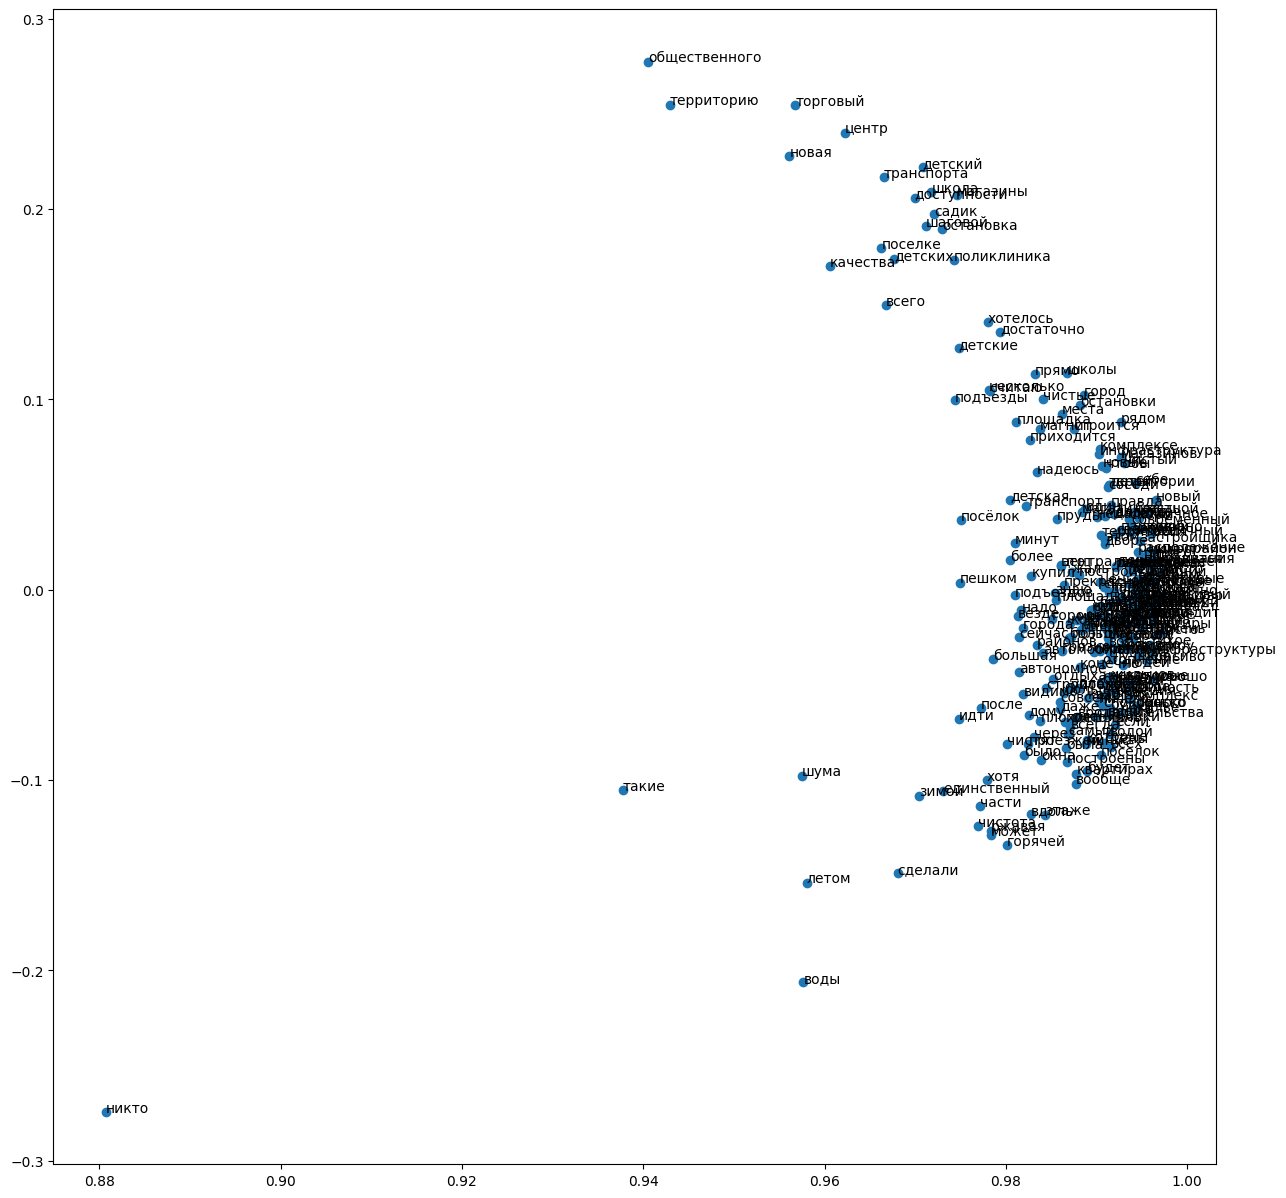

In [51]:
test_words = words
test_vectors = embed.get_vectors(*test_words)


fig, ax = plt.subplots()
fig.set_size_inches((15, 15))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

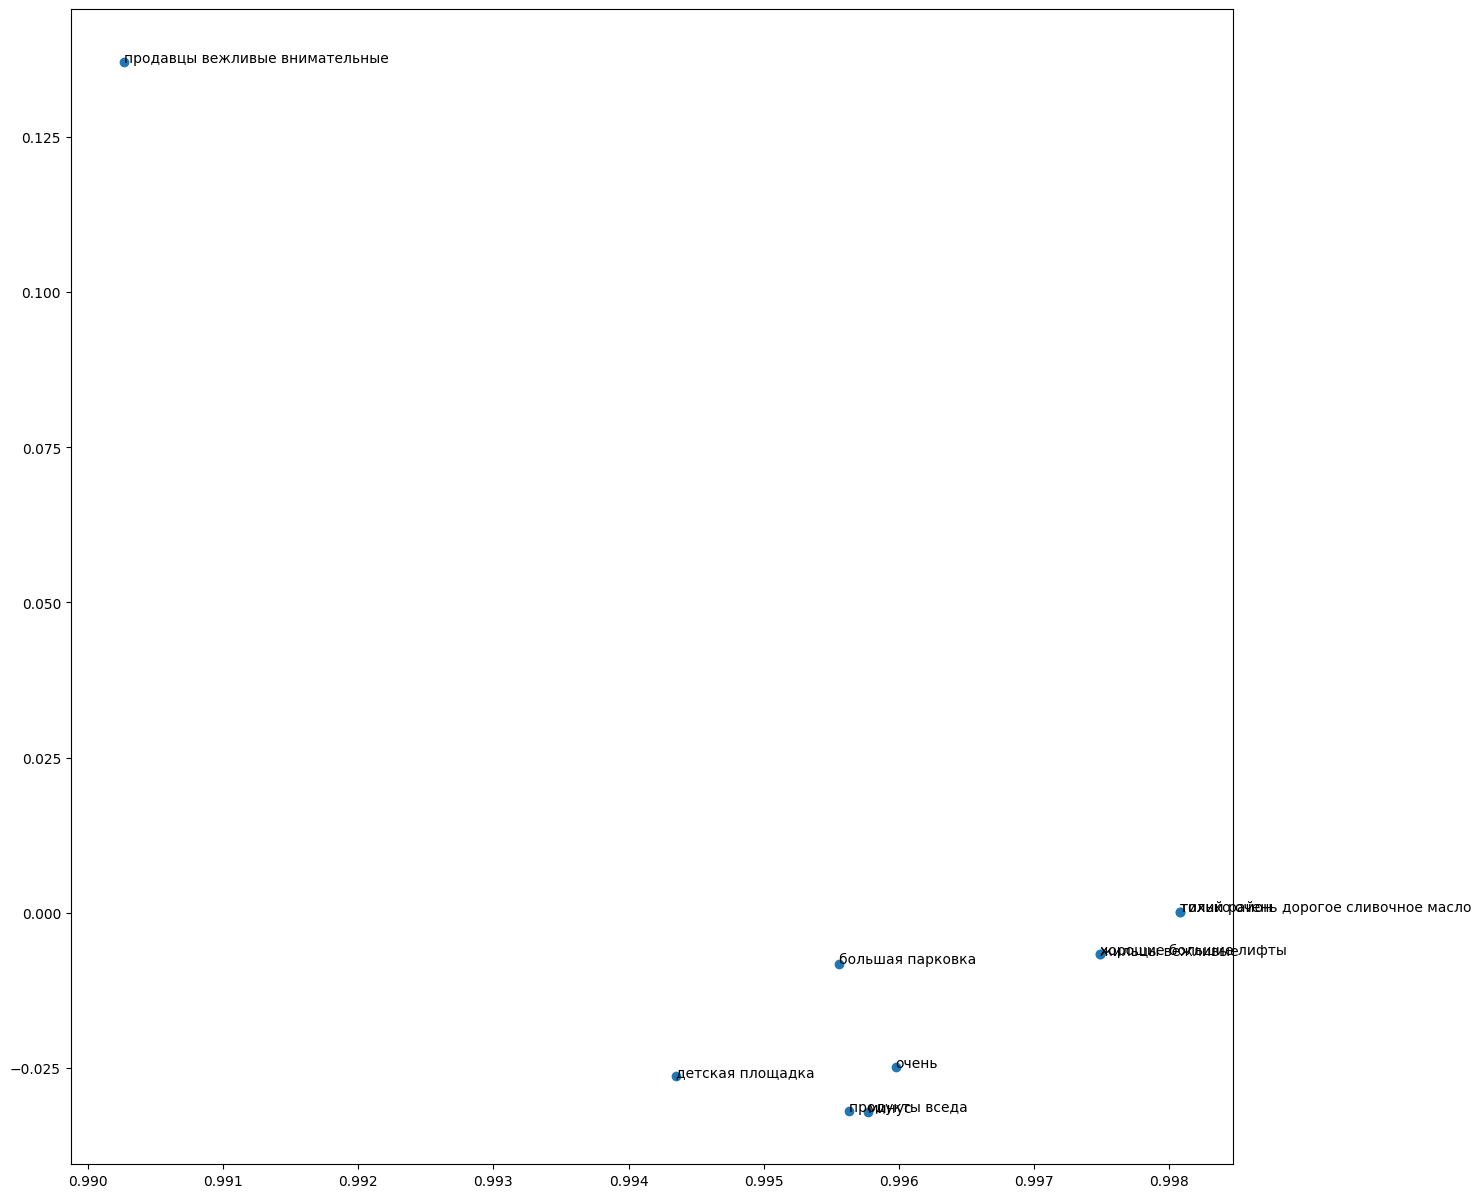

In [52]:
test_words = bert_key[0:100]
test_vectors = embed.get_vectors(*test_words)


fig, ax = plt.subplots()
fig.set_size_inches((15, 15))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)


In [53]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [54]:
embeddings.most_similar('парковка')

[('парковка', 0.9999005),
 ('большая', 0.89143723),
 ('подземная', 0.8612068),
 ('дворах', 0.80328596),
 ('индивидуальное', 0.8002105),
 ('автомобилей', 0.79976875),
 ('места', 0.7790339),
 ('достаточно', 0.77670497),
 ('детская', 0.7602891),
 ('прекрасная', 0.7564484)]

In [55]:
# gensim

In [56]:
len(train_data)

972

In [57]:
word2vec2 = gensim.models.Word2Vec(sentences=train_tokens, vector_size=25,
                                  window=5, min_count=5, workers=4,
                                  sg=1, epochs=10)

In [58]:
words = list(w for w in word2vec2.wv.index_to_key)
words

['очень',
 'есть',
 'район',
 'рядом',
 'дома',
 'много',
 'хороший',
 'место',
 'только',
 'можно',
 'площадки',
 'комплекс',
 'квартиры',
 'квартиру',
 'магазины',
 'детские',
 'здесь',
 'инфраструктура',
 'новый',
 'будет',
 'микрорайон',
 'парк',
 'если',
 'этом',
 'отличный',
 'доступности',
 'площадка',
 'расположение',
 'нравится',
 'двор',
 'шаговой',
 'детей',
 'хорошо',
 'домов',
 'детский',
 'жилой',
 'хорошие',
 'города',
 'чисто',
 'магазинов',
 'красивый',
 'хорошая',
 'дворы',
 'минут',
 'школа',
 'было',
 'даже',
 'мест',
 'доме',
 'метро',
 'удобно',
 'парковка',
 'детская',
 'тоже',
 'территории',
 'большой',
 'вообще',
 'всегда',
 'дороги',
 'просто',
 'конечно',
 'окна',
 'живу',
 'целом',
 'красиво',
 'жить',
 'пока',
 'машин',
 'когда',
 'всех',
 'дворе',
 'жизни',
 'центра',
 'больше',
 'парковки',
 'один',
 'тихий',
 'школы',
 'чтобы',
 'плюс',
 'меня',
 'зимой',
 'внутри',
 'территория',
 'транспорта',
 'квартир',
 'чистый',
 'хватает',
 'магазин',
 'детских',


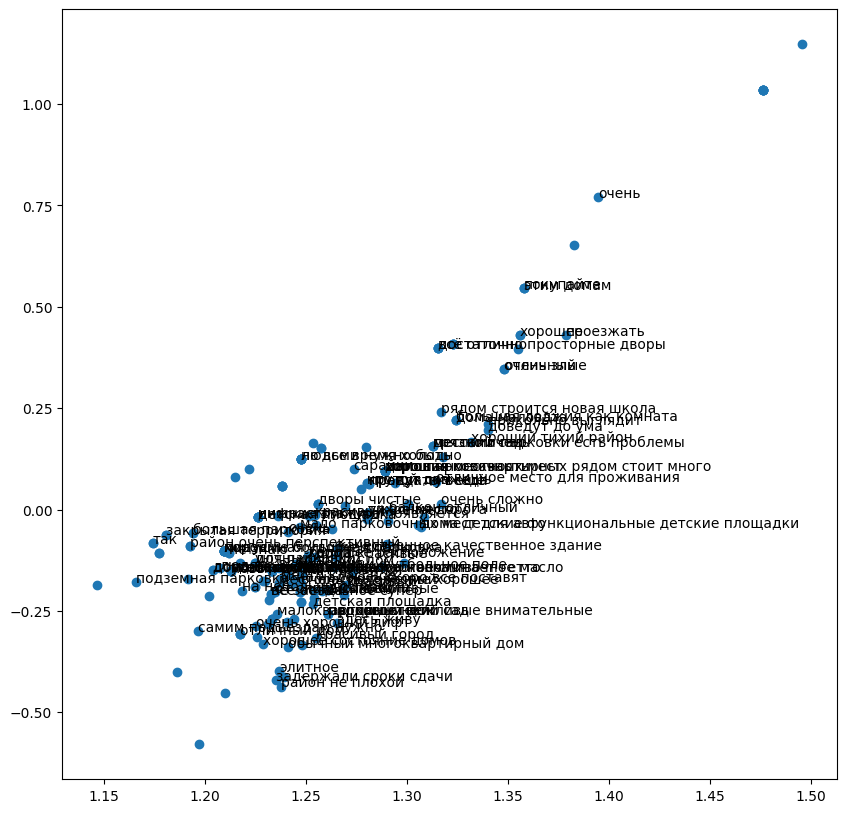

In [59]:


gensim_words = [w for w in bert_key if w in word2vec2.wv.key_to_index]
gensim_vectors = np.stack([word2vec2.wv[w] for w in gensim_words])

fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)



In [60]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(word2vec2, 25)
# Derive the vector for the word "science" in our model
vector = word2vec2.wv["парковка"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = word2vec2.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = word2vec2.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('парковка', 1.0)
('большая', 0.983793973910799)
('спортивная', 0.9822177873944885)
('прекрасная', 0.9814894784252313)
('маленькая', 0.9757038356423794)
('хорошая', 0.972574712179163)
('магазин', 0.9723244918552072)
('большой', 0.9721463340123452)
('чистота', 0.9719393816762371)
('зона', 0.9715686441335877)
('есть', 0.9715517740382427)

Exact Neighbors
('парковка', 1.0)
('большая', 0.9837939739227295)
('спортивная', 0.9822176694869995)
('прекрасная', 0.981489360332489)
('маленькая', 0.9757038950920105)
('хорошая', 0.9725747108459473)
('магазин', 0.972324550151825)
('большой', 0.9721463322639465)
('продуктовые', 0.9721454977989197)
('чистота', 0.971939206123352)
('зона', 0.9715686440467834)


In [121]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(word2vec2, 25)
# Derive the vector for the word "science" in our model
vector = word2vec2.wv["площадка"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = word2vec2.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = word2vec2.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('площадка', 1.0)
('дворе', 0.9301300699467983)
('детская', 0.9117385740180168)
('магазин', 0.9032931859708366)
('парковка', 0.8930059586828238)
('детей', 0.8857216211373427)
('каждом', 0.8844844044335485)
('спортивная', 0.8810002240986634)
('дворы', 0.8807318697969353)
('хорошая', 0.8767975593569406)
('большая', 0.8754801154404848)

Exact Neighbors
('площадка', 0.9999999403953552)
('дворе', 0.9301300644874573)
('детская', 0.9117386937141418)
('магазин', 0.9032931327819824)
('парковка', 0.893005907535553)
('детей', 0.8857216835021973)
('каждом', 0.8844844102859497)
('спортивная', 0.8810002207756042)
('дворы', 0.8807318210601807)
('хорошая', 0.8767974972724915)
('большая', 0.8754801154136658)


In [130]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(word2vec2, 25)
# Derive the vector for the word "science" in our model
vector = word2vec2.wv["советую"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = word2vec2.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = word2vec2.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('советую', 1.0)
('говорят', 0.9961513877533508)
('идёт', 0.995670318786551)
('ремонта', 0.9946572187656701)
('меньше', 0.9945582750290884)
('которая', 0.9943625923852935)
('квартира', 0.9943367246529529)
('считаю', 0.994279682921916)
('почему', 0.9939099548740729)
('большое', 0.9937562344339241)
('именно', 0.9937158815048799)

Exact Neighbors
('советую', 1.0)
('отвратительная', 0.9964259266853333)
('говорят', 0.996151328086853)
('идёт', 0.9956702589988708)
('ремонта', 0.9946571588516235)
('меньше', 0.9945583343505859)
('которая', 0.9943625330924988)
('бизнес', 0.9943597912788391)
('квартира', 0.9943366646766663)
('считаю', 0.9942796230316162)
('другой', 0.9940973520278931)


In [156]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(word2vec2, 25)
# Derive the vector for the word "science" in our model
vector = word2vec2.wv["расположение"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = word2vec2.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = word2vec2.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('расположение', 0.9999999403953572)
('минусов', 0.9730564361697986)
('недалеко', 0.9708752050083955)
('прогулок', 0.9675590955136624)
('детскими', 0.965335251966934)
('далеко', 0.965057191775422)
('домом', 0.9649462690285873)
('торговый', 0.9643101162315584)
('продуктовые', 0.9641046572076402)
('спортивная', 0.9637166851026375)
('братиславская', 0.9631606325705806)

Exact Neighbors
('расположение', 1.0)
('минусов', 0.9730563759803772)
('недалеко', 0.9708752632141113)
('прогулок', 0.9675592184066772)
('детскими', 0.9653353095054626)
('далеко', 0.9650571942329407)
('домом', 0.9649463891983032)
('остановка', 0.9648666977882385)
('торговый', 0.9643102884292603)
('продуктовые', 0.9641048908233643)
('спортивная', 0.9637167453765869)


In [152]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(word2vec2, 25)
# Derive the vector for the word "science" in our model
vector = word2vec2.wv["рядом"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = word2vec2.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = word2vec2.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('рядом', 1.0)
('остановка', 0.9747945053832882)
('аптеки', 0.9727203813299208)
('детский', 0.9717006667812836)
('магнит', 0.9671576597273552)
('инфраструктура', 0.9633123239283901)
('школы', 0.9614129028473424)
('школа', 0.9607064755216594)
('кафе', 0.9605627622212793)
('садик', 0.9598463164381807)
('магазины', 0.9549348398771964)

Exact Neighbors
('рядом', 1.0000001192092896)
('остановка', 0.9747945666313171)
('аптеки', 0.9727202653884888)
('детский', 0.9717006683349609)
('магнит', 0.9671576023101807)
('инфраструктура', 0.9633123278617859)
('школы', 0.9614130258560181)
('школа', 0.9607065320014954)
('кафе', 0.9605627655982971)
('садик', 0.9598464369773865)
('магазины', 0.9549348950386047)


In [163]:
word2vec2.save("New_90-10_kostroma_yaroslavl_moskva.model")

In [61]:
# new_df_ten_cities

# Word2Vec. 10 городов 



In [62]:
full_dataset = pd.read_csv('../dataset/2_0_ten_cities.csv', delimiter='\t',index_col=0)

In [63]:
#full_dateset = full_dateset.drop(['web-scraper-start-url'])
full_dataset

,review_link,author,message
houses_link,,,
Сказка Град,Отзывы,Александр Швыдков,"Отличный жк, двух уровневый. Все в плиточке и ..."
Сказка Град,Отзывы,Егор Табаков,"Отличный жк во всем, новые красивые дома, ухож..."
Сказка Град,Отзывы,Лемминг,"Территория ухожена, расположение домов позволя..."
Сказка Град,Отзывы,Татьяна Агафонова,"Отличный ЖК. Живем тут месяц, все радует. Крас..."
Сказка Град,Отзывы,Коренной,"Интересный Жк, большая территория закрытая\nВн..."
...,...,...,...
Парковый,Отзывы,Юлия Соловьева,Супер
Парковый,Отзывы,Михаил Малышев,Очень комфортные квартиры.
Парковый,Отзывы,Наталья К.,Красивые дома.


In [64]:
full_dataset = list(pd.read_csv('../dataset/2_0_ten_cities.csv', delimiter='\t',index_col=0)['message'].dropna())
full_dataset[115]

'Новый развивающийся микрорайон, есть садики, школа, отличные детские площадки, всё красиво ,красочно, чувствуется что застройщик думает о подрастающем поколении, чтоб вкус развивался.'

In [65]:
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.9)
train_data = full_dataset[:TRAIN_VAL_SPLIT]
test_data = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_data))
print("Тестовая выборка", len(test_data))
print()
print('\n'.join(train_data[:5]))

Обучающая выборка 2303
Тестовая выборка 256

Здравствуйте. Дом без газа будет? И что там с парковками для автомобилей? Место хорошее..... Но гаражи портят весь вид...
Забронировали квартиру, был предоставлен предварительный договор. Уже сделали согласие супруга на сделку около 3 т.р., т.к. застройщик просил отцифровать согласие, чтобы ускорить процесс. Сегодня застройщик позвонил и отменил всё, сказали, что сначала построят, а потом будут продавать, естественно уже по другому ценнику. Вот такие дела. Делайте выводы сами.
Хорошая локация комплекса , обустроенная придомовая территория . Очень дорогие кв , впрочем это во всех комплексах .
Спокойное тихое место, не хватает ассортимента в магазинах, добираться удобно, но долго. Люди здесь живут приятные и добрые.
Шикарный дом, о котором все думают, как о самом крутом. На самом деле обычный дом с удобным расположением, уютным двориком, подходящим для отдыха или прогулок с детьми. Оборудован двор велодорожками, детской площадкой, гамаками. В 

In [66]:
train_tokens = tokenize_corpus(train_data)
test_tokens = tokenize_corpus(test_data)

In [67]:
vocabulary, word_doc_freq = build_vocabulary(train_tokens, max_doc_freq=0.88, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2068
[('<PAD>', 0), ('очень', 1), ('есть', 2), ('рядом', 3), ('дома', 4), ('квартиру', 5), ('район', 6), ('комплекс', 7), ('много', 8), ('место', 9)]


In [68]:
train_tkn_id = texts_to_token_ids(train_tokens, vocabulary)
test_tkn_id = texts_to_token_ids(test_tokens, vocabulary)


In [69]:
MAX_SENTENCE_LEN = 30
train_dataset = PaddedSequenceDataset(train_tkn_id,
                                      np.zeros(len(train_tkn_id)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_tkn_id,
                                     np.zeros(len(test_tkn_id)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])


(tensor([ 10, 345, 763,   9,  62, 245,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]), tensor(0))


In [70]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [71]:
trainer = Trainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)

In [72]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_info,
                                            test_info,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=8,
                                            batch_size=1024,
                                            device='cpu',
                                            early_stopping_patience=5,
                                            max_batches_per_epoch_train=10000,
                                            max_batches_per_epoch_val=len(test_info),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0


/home/michalik/github/course_work/stepik_coursework_TextProcessing/All_Completed_Tasks_/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Эпоха: 1 итераций, 0.16 сек
Среднее значение функции потерь на обучении 0.9010915160179138
Среднее значение функции потерь на валидации 0.901089608669281
Новая лучшая модель!

Эпоха 1
Эпоха: 1 итераций, 0.12 сек
Среднее значение функции потерь на обучении 0.9010736346244812
Среднее значение функции потерь на валидации 0.900458812713623
Новая лучшая модель!

Эпоха 2
Эпоха: 1 итераций, 0.11 сек
Среднее значение функции потерь на обучении 0.9003766179084778
Среднее значение функции потерь на валидации 0.898694634437561
Новая лучшая модель!

Эпоха 3
Эпоха: 1 итераций, 0.12 сек
Среднее значение функции потерь на обучении 0.8984456658363342
Среднее значение функции потерь на валидации 0.8954017162322998
Новая лучшая модель!

Эпоха 4
Эпоха: 1 итераций, 0.10 сек
Среднее значение функции потерь на обучении 0.8948675394058228
Среднее значение функции потерь на валидации 0.8900468349456787
Новая лучшая модель!

Эпоха 5
Эпоха: 1 итераций, 0.11 сек
Среднее значение функции потерь на обучении 0.8892

In [73]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [74]:
embeddings.most_similar('парковка')

[('парковка', 0.99964225),
 ('есть', 0.9636316),
 ('просто', 0.9616245),
 ('цены', 0.9613513),
 ('которая', 0.96114904),
 ('район', 0.9599924),
 ('этот', 0.95919216),
 ('комплекс', 0.9590305),
 ('нашей', 0.9589022),
 ('жилой', 0.9588315)]

In [75]:
# gensim

In [76]:
len(train_data)

2303

In [77]:
final_word2vec = gensim.models.Word2Vec(sentences=train_tokens, vector_size=30,
                                  window=4, min_count=5, workers=4,
                                  sg=1, epochs=20)

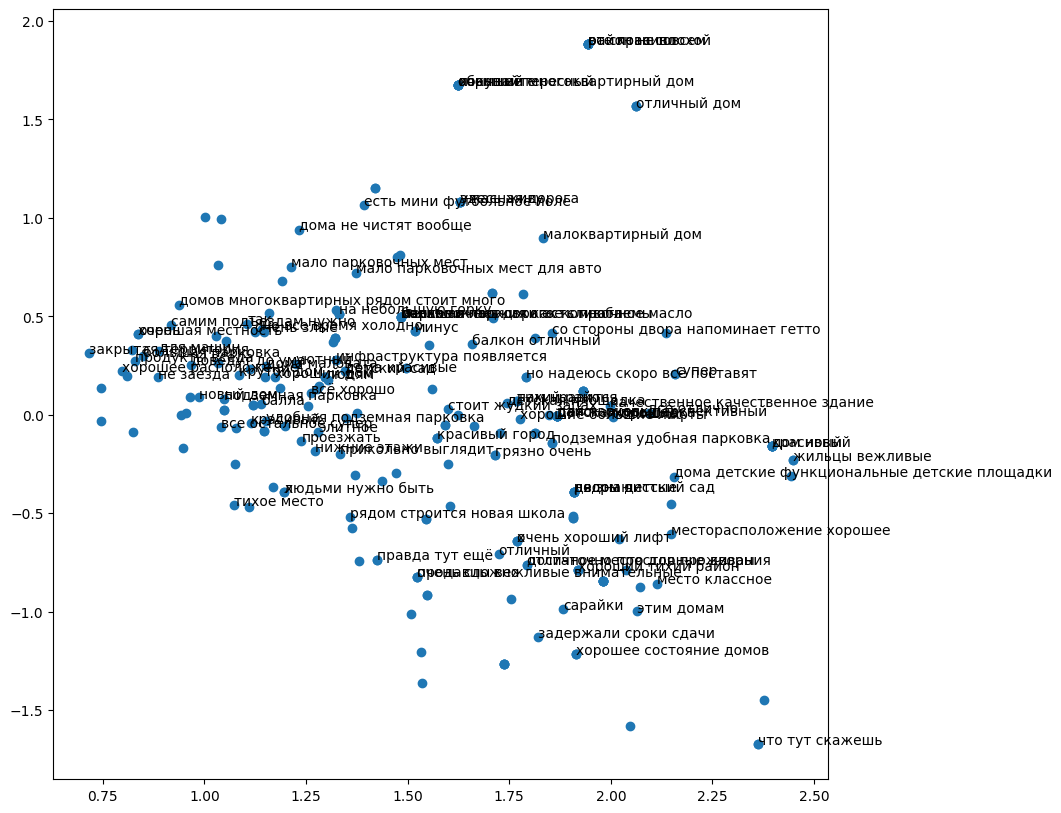

In [78]:
gensim_words = [w for w in bert_key if w in final_word2vec.wv.key_to_index]
gensim_vectors = np.stack([final_word2vec.wv[w] for w in gensim_words])

fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)


In [79]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(final_word2vec, 25)
# Derive the vector for the word "science" in our model
vector = final_word2vec.wv["мест"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = final_word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = final_word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('мест', 1.0)
('парковочных', 0.8645779988469258)
('автотранспорта', 0.801051201422835)
('гостей', 0.7866006925365738)
('маловато', 0.7738545487065309)
('общего', 0.7309057103221264)
('платная', 0.7147255346626977)
('московском', 0.6894646460851686)
('хватит', 0.6864049652956226)
('подземной', 0.6838265444301737)
('мало', 0.6725898753858086)

Exact Neighbors
('мест', 1.0)
('парковочных', 0.8645779490470886)
('автотранспорта', 0.8010512590408325)
('гостей', 0.786600649356842)
('маловато', 0.7738544940948486)
('новостроек', 0.7425689697265625)
('общего', 0.7309057116508484)
('платная', 0.7147254347801208)
('общая', 0.6951408982276917)
('московском', 0.6894646883010864)
('хватит', 0.6864050030708313)


In [141]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(final_word2vec, 25)
# Derive the vector for the word "science" in our model
vector = final_word2vec.wv["советую"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = final_word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = final_word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('советую', 1.0)
('дела', 0.8801405927925212)
('мнение', 0.8484463074781843)
('зайти', 0.8421473459842002)
('самим', 0.82676029654783)
('ситуация', 0.8067746133524452)
('поможет', 0.8060684369416418)
('будете', 0.804795443994287)
('сравнивать', 0.8047921666310955)
('можем', 0.8045147200940459)
('этим', 0.8018554747963833)

Exact Neighbors
('советую', 0.9999998807907104)
('дела', 0.8801405429840088)
('мнение', 0.8484463095664978)
('зайти', 0.8421472907066345)
('менеджеры', 0.8313894867897034)
('самим', 0.8267602920532227)
('кофе', 0.8175978660583496)
('ситуация', 0.8067746162414551)
('поможет', 0.8060684204101562)
('будете', 0.8047953844070435)
('сравнивать', 0.8047922253608704)


In [81]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(final_word2vec, 25)
# Derive the vector for the word "science" in our model
vector = final_word2vec.wv["парковка"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = final_word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = final_word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('парковка', 1.0)
('подземная', 0.795619677661092)
('платная', 0.7887636140775651)
('многоуровневая', 0.7846108562632423)
('автомобилей', 0.7512463772539419)
('уютная', 0.7380973723464876)
('маленькая', 0.7307005052371593)
('местных', 0.7286530663821207)
('охрана', 0.7196373783514716)
('красоту', 0.7005937526873947)
('консьержки', 0.6991876344777932)

Exact Neighbors
('парковка', 1.0000001192092896)
('подземная', 0.795619547367096)
('платная', 0.788763701915741)
('многоуровневая', 0.78461092710495)
('автомобилей', 0.7512463331222534)
('уютная', 0.7380973696708679)
('маленькая', 0.7307004928588867)
('местных', 0.7286531329154968)
('охрана', 0.719637393951416)
('красоту', 0.7005938291549683)
('консьержки', 0.699187695980072)


In [122]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(final_word2vec, 25)
# Derive the vector for the word "science" in our model
vector = final_word2vec.wv["площадка"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = final_word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = final_word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('площадка', 0.9999998807907104)
('игровая', 0.8960219567429419)
('спортивная', 0.8651160610048532)
('зона', 0.8365936412685056)
('барбекю', 0.8106236927719621)
('детская', 0.8088525422044466)
('комната', 0.8073200604203077)
('тренажерами', 0.8066915679284516)
('огорожена', 0.7968203266648786)
('студия', 0.795211987129278)
('зелёная', 0.7932401961509168)

Exact Neighbors
('площадка', 1.0)
('игровая', 0.8960219025611877)
('спортивная', 0.8651161789894104)
('зона', 0.8365936875343323)
('барбекю', 0.8106237649917603)
('детская', 0.8088526129722595)
('комната', 0.8073200583457947)
('тренажерами', 0.8066917061805725)
('огорожена', 0.7968204617500305)
('студия', 0.795211911201477)
('зелёная', 0.7932401895523071)


In [157]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(final_word2vec, 25)
# Derive the vector for the word "science" in our model
vector = final_word2vec.wv["рядом"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = final_word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = final_word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('рядом', 1.0)
('больница', 0.8792520197715912)
('роща', 0.856851290248521)
('вознесенский', 0.8564521645855336)
('победы', 0.8506055296938495)
('недалеко', 0.8442778708894547)
('поликлиника', 0.8382183779057186)
('трамвая', 0.837685228994701)
('автобусная', 0.8348945517308266)
('волга', 0.8341162714568782)
('река', 0.8334374216514941)

Exact Neighbors
('рядом', 0.9999998807907104)
('больница', 0.8792521357536316)
('роща', 0.8568512797355652)
('вознесенский', 0.8564521670341492)
('победы', 0.8506054282188416)
('недалеко', 0.8442777991294861)
('поликлиника', 0.8382183313369751)
('трамвая', 0.8376851677894592)
('автобусная', 0.8348945379257202)
('волга', 0.8341163396835327)
('река', 0.8334373831748962)


In [159]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(final_word2vec, 25)
# Derive the vector for the word "science" in our model
vector = final_word2vec.wv["расположение"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = final_word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = final_word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('расположение', 1.0)
('месторасположение', 0.8430566715918459)
('местоположение', 0.8276413103331421)
('удобное', 0.7587771461211741)
('решение', 0.7424407747544635)
('идеальное', 0.7356227813373959)
('экологически', 0.7327998010156431)
('удачное', 0.715744960045738)
('нового', 0.7135612009323165)
('действительно', 0.7071364425849094)
('благоустройство', 0.6888887221002662)

Exact Neighbors
('расположение', 1.0000001192092896)
('месторасположение', 0.8430567383766174)
('местоположение', 0.8276413679122925)
('удобное', 0.7587770819664001)
('решение', 0.7424407005310059)
('идеальное', 0.7356228828430176)
('экологически', 0.7327998280525208)
('плане', 0.7160761952400208)
('удачное', 0.7157448530197144)
('нового', 0.7135611176490784)
('действительно', 0.7071363925933838)


In [165]:
final_word2vec.save("New_90-10_10cities.model")

# Word2Vec. 14 городов 



In [84]:
full_dataset = pd.read_csv('../dataset/14_cities.csv', delimiter='\t',index_col=0)

In [85]:
#full_dateset = full_dateset.drop(['web-scraper-start-url'])
full_dataset

,review_link,author,message
houses_link,,,
Факел,Отзывы,Андрей Алексеенков,Очень классный комплекс. В домах по два подъе...
Факел,Отзывы,Первое,Современный ЖК с крутой инфраструктурой. Есть ...
Факел,Отзывы,Марина D,Добрый день!\nСкажу за себя - ожидание и реаль...
Факел,Отзывы,sonya sonya,"Удобное расположение, рядом автобусная останов..."
Факел,Отзывы,Юлия Тимохина,Расположен практически в центре города.Отлична...
...,...,...,...
Парковый,Отзывы,Юлия Соловьева,Супер
Парковый,Отзывы,Михаил Малышев,Очень комфортные квартиры.
Парковый,Отзывы,Наталья К.,Красивые дома.


In [86]:
full_dataset = list(pd.read_csv('../dataset/14_cities.csv', delimiter='\t',index_col=0)['message'].dropna())
full_dataset[115]

'Когда все строительные работы завершатся будет очень красиво и комфортно, это прослеживается уже и сейчас'

In [87]:
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.9)
train_data = full_dataset[:TRAIN_VAL_SPLIT]
test_data = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_data))
print("Тестовая выборка", len(test_data))
print()
print('\n'.join(train_data[:5]))

Обучающая выборка 3044
Тестовая выборка 339

Место просто космос, захотелось тут жить с первого взгляда. Но мы конечно не дураки, на первое впечатление не ведемся, ознакомились подробнее. Остановились по итогу на Острове 6, тут прикольно, большие площадки для детворы, садик, детский клуб вроде даже обещают. Для семьи больше подходит, чем все остальные кварталы.
Новый современный район, который отличается от муравейников (Девяткино и Марино). Здесь крутая природа, очень тихо и хорошие люди. Транспортная доступность — намного лучше, чем все думают. Красивые дворы, ландшафтный дизайн. От своего дома добираюсь до центра (Гостиный двор) за 40 минут. Перспективный район.
Купили квартиру в ЖК Отражение по совету друзей, они были первооткрывателями) ключи выдали раньше положенного срока! Всем довольны
Чудесный жилой комплекс! Большая площадка для детей, есть беседки и мангальная зона. УК работает на высшем уровне (есть с чем сравнить😅), всегда чисто, территория ухоженная, зелёная. В моём доме 

In [135]:
print("Обучающая выборка", len(train_data))


Обучающая выборка 3044


In [88]:
train_tokens = tokenize_corpus(train_data)
test_tokens = tokenize_corpus(test_data)

In [89]:
vocabulary, word_doc_freq = build_vocabulary(train_tokens, max_doc_freq=0.88, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2584
[('<PAD>', 0), ('очень', 1), ('есть', 2), ('дома', 3), ('рядом', 4), ('район', 5), ('много', 6), ('комплекс', 7), ('квартиру', 8), ('место', 9)]


In [90]:
train_tkn_id = texts_to_token_ids(train_tokens, vocabulary)
test_tkn_id = texts_to_token_ids(test_tokens, vocabulary)


In [91]:
MAX_SENTENCE_LEN = 30
train_dataset = PaddedSequenceDataset(train_tkn_id,
                                      np.zeros(len(train_tkn_id)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_tkn_id,
                                     np.zeros(len(test_tkn_id)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])


(tensor([   9,   35, 1432,   82,  793,   66, 1801,  851, 2132, 1595, 1042, 2131,
         151,   14,  135,   45,  903,  261,   40,  518,  403,  104, 1802, 1043,
           0,    0,    0,    0,    0,    0]), tensor(0))


In [92]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [93]:
trainer = Trainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)

In [94]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_info,
                                            test_info,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=8,
                                            batch_size=1024,
                                            device='cpu',
                                            early_stopping_patience=5,
                                            max_batches_per_epoch_train=10000,
                                            max_batches_per_epoch_val=len(test_info),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 1 итераций, 0.13 сек
Среднее значение функции потерь на обучении 0.9010911583900452
Среднее значение функции потерь на валидации 0.9010328650474548
Новая лучшая модель!

Эпоха 1


/home/michalik/github/course_work/stepik_coursework_TextProcessing/All_Completed_Tasks_/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Эпоха: 1 итераций, 0.14 сек
Среднее значение функции потерь на обучении 0.9010123610496521
Среднее значение функции потерь на валидации 0.9001671075820923
Новая лучшая модель!

Эпоха 2
Эпоха: 1 итераций, 0.11 сек
Среднее значение функции потерь на обучении 0.9000439047813416
Среднее значение функции потерь на валидации 0.8979563117027283
Новая лучшая модель!

Эпоха 3
Эпоха: 1 итераций, 0.12 сек
Среднее значение функции потерь на обучении 0.8976077437400818
Среднее значение функции потерь на валидации 0.8940480351448059
Новая лучшая модель!

Эпоха 4
Эпоха: 1 итераций, 0.10 сек
Среднее значение функции потерь на обучении 0.8932791948318481
Среднее значение функции потерь на валидации 0.8883779644966125
Новая лучшая модель!

Эпоха 5
Эпоха: 1 итераций, 0.11 сек
Среднее значение функции потерь на обучении 0.8868842124938965
Среднее значение функции потерь на валидации 0.8804398775100708
Новая лучшая модель!

Эпоха 6
Эпоха: 1 итераций, 0.11 сек
Среднее значение функции потерь на обучении 0.8

In [95]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [96]:
embeddings.most_similar('парковка')

[('парковка', 0.9996526),
 ('много', 0.96817),
 ('стоит', 0.9659507),
 ('этого', 0.9646522),
 ('минусы', 0.9633135),
 ('есть', 0.9628446),
 ('проект', 0.96272206),
 ('хорошие', 0.96266323),
 ('расположение', 0.9624219),
 ('территория', 0.9613999)]

In [97]:
# gensim

In [98]:
len(train_data)

3044

In [99]:
finals_word2vec = gensim.models.Word2Vec(sentences=train_tokens, vector_size=30,
                                  window=4, min_count=5, workers=4,
                                  sg=1, epochs=20)

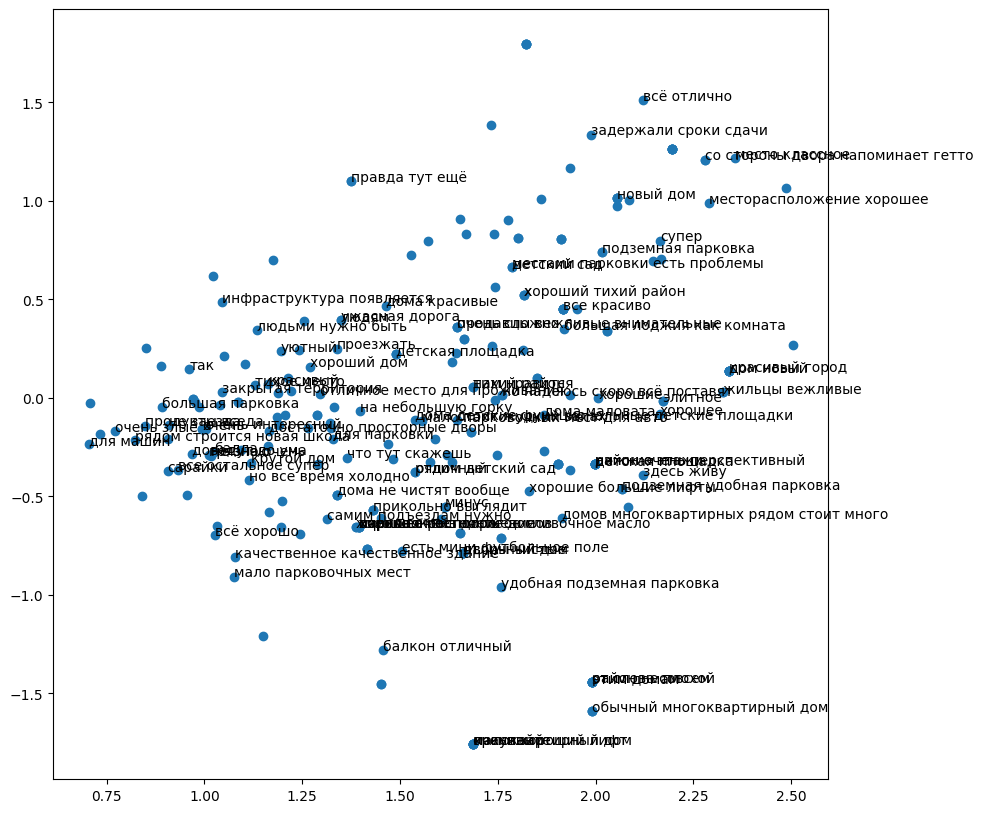

In [100]:
gensim_words = [w for w in bert_key if w in finals_word2vec.wv.key_to_index]
gensim_vectors = np.stack([finals_word2vec.wv[w] for w in gensim_words])

fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)


In [154]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(finals_word2vec, 25)
# Derive the vector for the word "science" in our model
vector = finals_word2vec.wv["рядом"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = finals_word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = finals_word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('рядом', 1.0)
('больница', 0.8851017882149743)
('ашан', 0.8793362315172999)
('недалеко', 0.8692468546749978)
('боком', 0.8639137647689505)
('вознесенский', 0.8627663767251761)
('пляж', 0.859477158116583)
('мега', 0.8586983760500786)
('бассейн', 0.8560787387930855)
('речка', 0.8483763696876974)
('автобусная', 0.8476651818695142)

Exact Neighbors
('рядом', 1.0)
('больница', 0.8851017951965332)
('ашан', 0.8793362379074097)
('недалеко', 0.8692468404769897)
('боком', 0.8639137148857117)
('вознесенский', 0.862766444683075)
('пляж', 0.8594772219657898)
('мега', 0.858698308467865)
('бассейн', 0.8560786843299866)
('речка', 0.8483763337135315)
('автобусная', 0.8476652503013611)


In [102]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(final_word2vec, 25)
# Derive the vector for the word "science" in our model
vector = finals_word2vec.wv["площадка"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = finals_word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = finals_word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('точки', 0.7146518285883854)
('районом', 0.7143514128061792)
('обожаю', 0.6990186789301287)
('спальном', 0.680750997000807)
('сути', 0.6782737592911232)
('хотелось', 0.6778482339128953)
('глазах', 0.6778106754617284)
('зеленстрой', 0.6678121049415306)
('град', 0.6676724132737419)
('проекте', 0.6591316679328472)
('случайно', 0.657534530511624)

Exact Neighbors
('площадка', 0.9999999403953552)
('детская', 0.9051510095596313)
('спортивная', 0.8216153979301453)
('игровая', 0.8141902089118958)
('баскетбольная', 0.8067622184753418)
('беседки', 0.7624780535697937)
('качели', 0.7614309191703796)
('тренажеры', 0.752759575843811)
('тренажерами', 0.7497805953025818)
('зона', 0.7489098310470581)
('гаражи', 0.7295297384262085)


In [103]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(finals_word2vec, 25)
# Derive the vector for the word "science" in our model
vector = finals_word2vec.wv["парковка"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = finals_word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = finals_word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('парковка', 1.0)
('подземная', 0.8166116863284287)
('многоуровневая', 0.8020117606767982)
('платная', 0.7814048845861805)
('красоту', 0.7539397189461567)
('маленькая', 0.7326103573500404)
('стоянка', 0.7229547115118464)
('предусмотрена', 0.7102751122262543)
('паркинга', 0.6923784346131399)
('есть', 0.6783228605035969)
('доступа', 0.6761145374326656)

Exact Neighbors
('парковка', 1.0)
('подземная', 0.816611647605896)
('многоуровневая', 0.8020116686820984)
('платная', 0.7814047932624817)
('красоту', 0.753939688205719)
('маленькая', 0.7326103448867798)
('стоянка', 0.7229546308517456)
('предусмотрена', 0.7102750539779663)
('валет', 0.7066162824630737)
('паркинга', 0.6923783421516418)
('есть', 0.6783229112625122)


In [144]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(finals_word2vec, 25)
# Derive the vector for the word "science" in our model
vector = finals_word2vec.wv["советую"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = finals_word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = finals_word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('советую', 1.0)
('людям', 0.7404996566983755)
('хочется', 0.7395280427468762)
('тебя', 0.7355559440314448)
('такими', 0.7077133970591216)
('моим', 0.7067621715474512)
('кофе', 0.7049697884494606)
('подумать', 0.7035285810654965)
('берут', 0.699936311841908)
('дают', 0.6963787998973157)
('человека', 0.691807463920723)

Exact Neighbors
('советую', 1.0000001192092896)
('живёшь', 0.755044162273407)
('людям', 0.7404996156692505)
('хочется', 0.7395281195640564)
('тебя', 0.7355559468269348)
('такими', 0.7077134847640991)
('моим', 0.7067621350288391)
('кофе', 0.7049698233604431)
('подумать', 0.7035285234451294)
('берут', 0.6999363303184509)
('дают', 0.696378767490387)


In [150]:
from gensim.similarities.annoy import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(finals_word2vec, 25)
# Derive the vector for the word "science" in our model
vector = finals_word2vec.wv["расположение"]
# The instance of AnnoyIndexer we just created is passed
approximate_neighbors = finals_word2vec.wv.most_similar([vector], topn=11, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    print(neighbor)


normal_neighbors = finals_word2vec.wv.most_similar([vector], topn=11)
print("\nExact Neighbors")
for neighbor in normal_neighbors:
    print(neighbor)

Approximate Neighbors
('расположение', 1.0)
('месторасположение', 0.8254761028409803)
('местоположение', 0.8155650571756592)
('удобное', 0.8040004375870478)
('удачное', 0.7774485455674505)
('комфортное', 0.7444182449155221)
('боком', 0.7376785459039734)
('зрения', 0.7315848826092406)
('идеальное', 0.7281452362690839)
('продуманная', 0.7234659061669344)
('точки', 0.7213986743736243)

Exact Neighbors
('расположение', 1.0)
('месторасположение', 0.8254760503768921)
('местоположение', 0.8155649900436401)
('удобное', 0.8040003776550293)
('удачное', 0.7774485349655151)
('комфортное', 0.744418203830719)
('благоустройство', 0.738867461681366)
('боком', 0.7376784086227417)
('зрения', 0.7315847873687744)
('идеальное', 0.7281452417373657)
('продуманная', 0.7234658598899841)


In [164]:
finals_word2vec.save("New_90-10_14cities.model")